In [52]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")
from nlp_utils import remove_stopwords, normalize_corpus
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gc

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
df = pd.read_csv("data/autism-women.csv")
#df.drop(["id","created", "url", "Unnamed: 0"], axis = 1, inplace=True)
df.head()

,Unnamed: 0,title,score,id,url,num_comments,created,text
0,0,A company is falsely using our sub to market t...,433,11s0vyi,https://www.reddit.com/r/AutismInWomen/comment...,11,1.678897e+09,"Hi Everyone,\n\nWe’ve recently found out a com..."
1,1,Megathread for New Banner,25,12b4m5h,https://www.reddit.com/r/AutismInWomen/comment...,27,1.680571e+09,We’d like to have a banner the members feel re...
2,2,Made a homemade pizza for the first time. It w...,267,13gxtxy,https://i.redd.it/vwjoycl3jqza1.jpg,14,1.684025e+09,It was a new experience for me working with ye...
3,3,Is anyone straight but often assumed to be gay?,183,13gvkev,https://www.reddit.com/r/AutismInWomen/comment...,100,1.684019e+09,I'm not offended by it but I don't know how ma...
4,4,Mother's Day card for my also autistic mom! Sh...,67,13h13xc,https://www.reddit.com/gallery/13h13xc,2,1.684034e+09,Second image is a doodle of our little dog :-)


In [54]:
df2 = pd.read_csv("data/autism-women-2.csv")
#df.drop(["id","created", "url", "Unnamed: 0"], axis = 1, inplace=True)
df2.head()

,Unnamed: 0,title,score,id,url,num_comments,created,text
0,0,A company is falsely using our sub to market t...,435,11s0vyi,https://www.reddit.com/r/AutismInWomen/comment...,11,1.678897e+09,"Hi Everyone,\n\nWe’ve recently found out a com..."
1,1,Megathread for New Banner,26,12b4m5h,https://www.reddit.com/r/AutismInWomen/comment...,27,1.680571e+09,We’d like to have a banner the members feel re...
2,2,boobs optional,268,13i699x,https://www.reddit.com/r/AutismInWomen/comment...,71,1.684152e+09,I want a double mastectomy. I want to wear fak...
3,3,Does anyone else do this? Just curious.,35,13ic7wj,https://i.redd.it/cshcnc5j720b1.jpg,17,1.684166e+09,Literally holding my left hand like this all t...
4,4,I've just gotten to the point where I let peop...,45,13i6e2a,https://www.reddit.com/r/AutismInWomen/comment...,2,1.684153e+09,"33, had to unlearn a LOT of sh\*\* programming..."


In [55]:
frames = [df,df2]
new_df = pd.concat(frames)
new_df.head()

,Unnamed: 0,title,score,id,url,num_comments,created,text
0,0,A company is falsely using our sub to market t...,433,11s0vyi,https://www.reddit.com/r/AutismInWomen/comment...,11,1.678897e+09,"Hi Everyone,\n\nWe’ve recently found out a com..."
1,1,Megathread for New Banner,25,12b4m5h,https://www.reddit.com/r/AutismInWomen/comment...,27,1.680571e+09,We’d like to have a banner the members feel re...
2,2,Made a homemade pizza for the first time. It w...,267,13gxtxy,https://i.redd.it/vwjoycl3jqza1.jpg,14,1.684025e+09,It was a new experience for me working with ye...
3,3,Is anyone straight but often assumed to be gay?,183,13gvkev,https://www.reddit.com/r/AutismInWomen/comment...,100,1.684019e+09,I'm not offended by it but I don't know how ma...
4,4,Mother's Day card for my also autistic mom! Sh...,67,13h13xc,https://www.reddit.com/gallery/13h13xc,2,1.684034e+09,Second image is a doodle of our little dog :-)


In [56]:
new_df['id'].count()

1995

In [57]:
new_df['id'].nunique()

1109

In [58]:
new_df.drop_duplicates('id', inplace=True)
new_df.drop([0, 1], inplace=True)
new_df['id'].count()

1107

In [59]:
df = new_df.copy()

## Cleaning

In [60]:
df.shape

(1107, 8)

In [61]:
df.dropna(inplace=True)

In [62]:
df.shape

(1059, 8)

In [63]:
df["score"] = df["score"].astype("int32")
df["num_comments"] = df["num_comments"].astype("int32")

In [64]:
df_title = df[["title", "score",
               "num_comments"]]
df_title.head()

,title,score,num_comments
2,Made a homemade pizza for the first time. It w...,267,14
3,Is anyone straight but often assumed to be gay?,183,100
4,Mother's Day card for my also autistic mom! Sh...,67,2
5,Anyone else accidentally stare at boobs while ...,65,19
6,"Scared I'll be chronically homeless til I die,...",51,5


In [65]:
df_title.describe()

,score,num_comments
count,1059.000000,1059.000000
mean,40.554297,15.227573
std,113.811345,33.657933
min,0.000000,0.000000
25%,3.000000,2.000000
50%,6.000000,4.000000
75%,21.500000,13.000000
max,1115.000000,457.000000


## Data Analysis

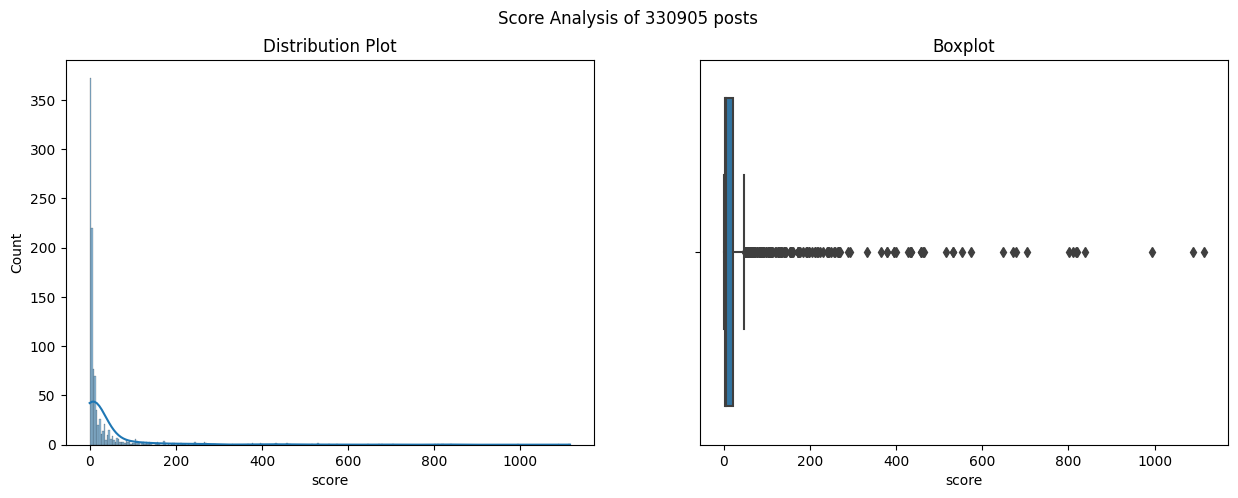

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Score Analysis of 330905 posts')

sns.histplot(ax=axes[0], x="score", data=df_title, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="score", data=df_title)
axes[1].set_title("Boxplot")

plt.show()

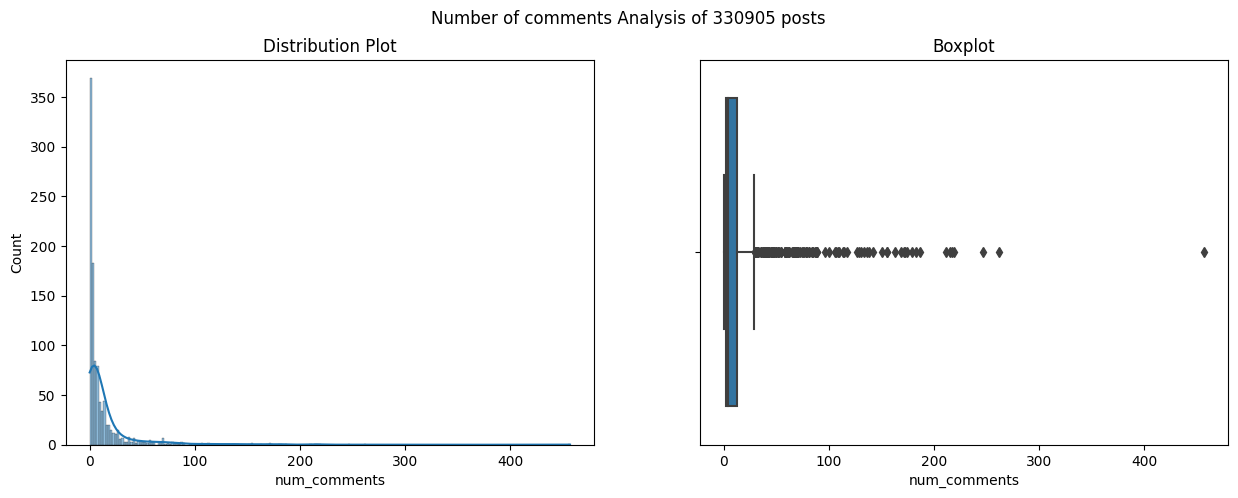

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Number of comments Analysis of 330905 posts')

sns.histplot(ax=axes[0], x="num_comments", data=df_title, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="num_comments", data=df_title)
axes[1].set_title("Boxplot")

plt.show()

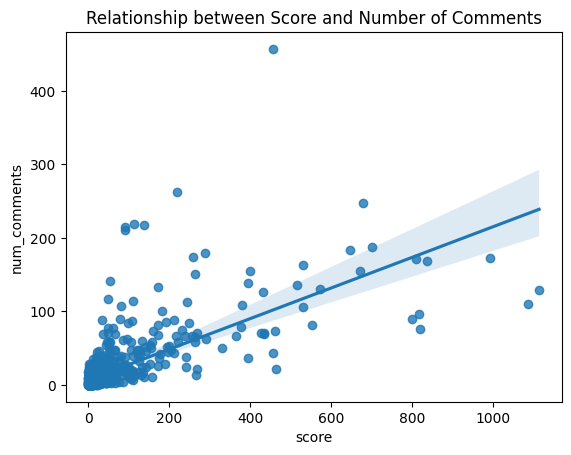

In [68]:
sns.regplot(x="score",
            y="num_comments",
            data=df)
plt.title("Relationship between Score and Number of Comments")
plt.show()

## Title Analysis

In [69]:
df_title["title"] = normalize_corpus(df_title["title"])

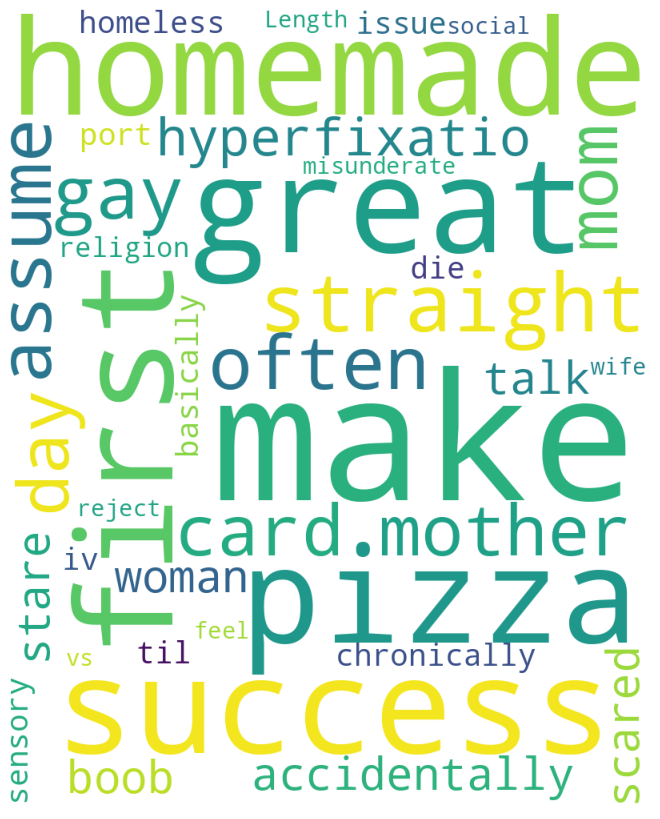

In [70]:
new_stopwords = ["autistic", "autism", "title", 
                 "text", "subreddit", "dtype",
                 "length" "thread", "object",
                 "Name", "asd", "disorder", "spectrum",
                 "megathread", "syndrome", "falsely", "sub",
                 "c"]

stopwords = list(STOPWORDS) + new_stopwords
wordcloud = (WordCloud(width = 800, height = 1000,
                max_words=400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 12)
                .generate(str(df_title["title"])))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), 
           facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

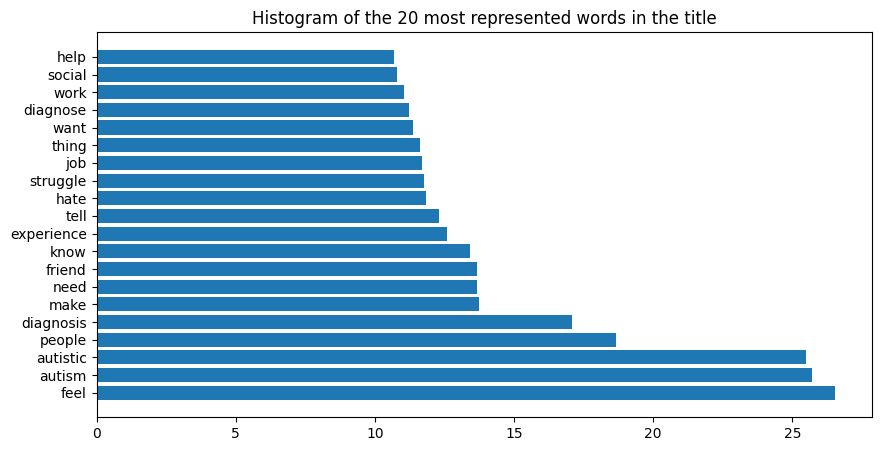

In [71]:
vectorizer_tf = TfidfVectorizer(max_features=1000)
tfidf_title = vectorizer_tf.fit_transform(df_title['title']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.sum(), columns=["Value"])
top_20_title_word_tf = df_title_tf.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word_tf.index, width=top_20_title_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the title")
plt.show()

In [72]:
df_title.to_csv("data/autism-women-title.csv")

In [73]:
del(df_title)
gc.collect()

30401

## Content Analysis

In [74]:
df_text = df[["text", "score", 
              "num_comments"]]

In [75]:
df_text["text"] = normalize_corpus(df_text["text"])

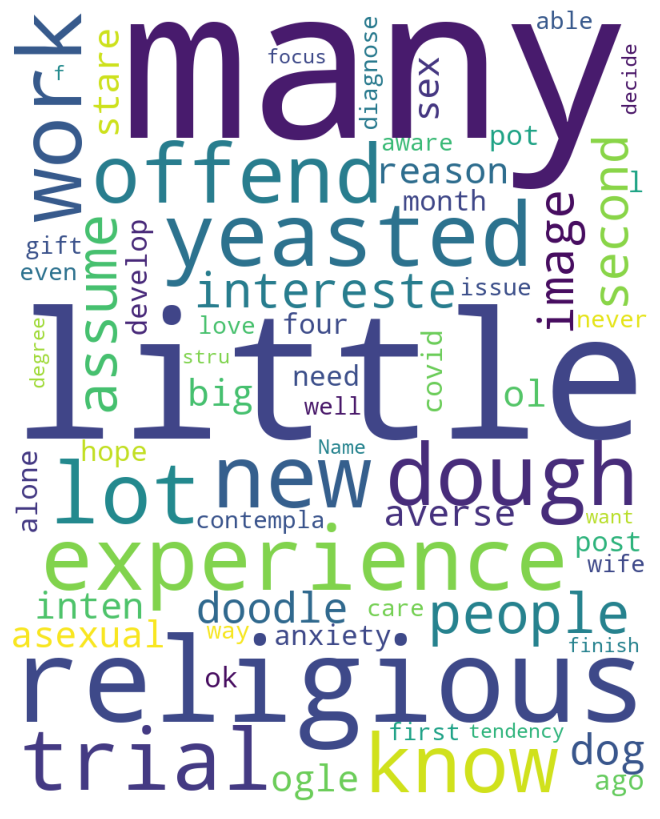

In [76]:
new_stopwords = ["autism", "autist", "length",
                 "object", "object", "text",
                 "sub", "dtype","wee", "kinda", "l"]

stopwords = list(STOPWORDS) + new_stopwords
wordcloud = (WordCloud(width = 800, height = 1000,
                max_words=200,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 12)
                .generate(str(df_text["text"])))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), 
           facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

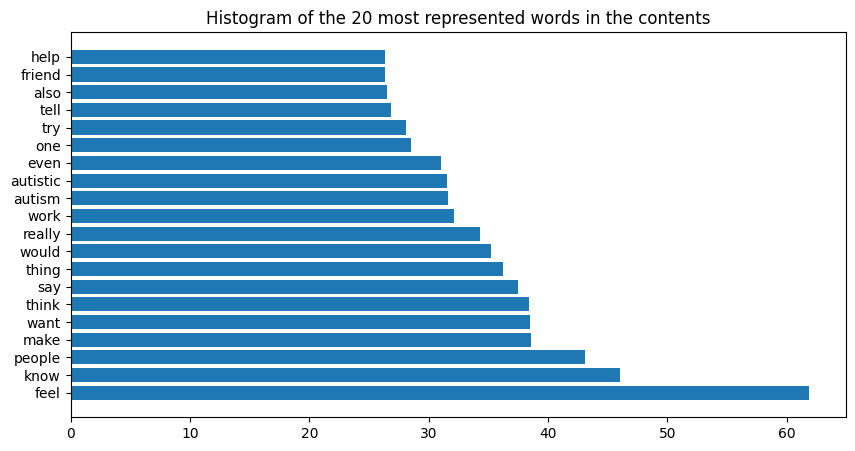

In [77]:
vectorizer_tf = TfidfVectorizer(max_features=1000)
tfidf_title = vectorizer_tf.fit_transform(df_text['text']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.sum(), columns=["Value"])
top_20_title_word_tf = df_title_tf.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word_tf.index, width=top_20_title_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the contents")
plt.show()

In [78]:
df_text.to_csv("data/autism-women-text.csv")